In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from pathlib import Path
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Flatten, LSTM, SimpleRNN
%run WordEmbeddings.ipynb

In [33]:
# Setup tensorboard environment
%reload_ext tensorboard
logdir=Path("./logs/fit/newsplay" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                       lookback,
                       data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
def alt_generator(data, lookback, delay, indices, batch_size=32):
    min_index = lookback
    max_index = len(data) - delay - 1
    current_batch_start = 0
    while True:
        if current_batch_start > len(indices): 
            current_batch_start = 0
        rows = indices[current_batch_start:min(current_batch_start+batch_size,max_index)]
        current_batch_start += batch_size
        samples = np.zeros((len(rows), lookback, data.shape[-1]))
        targets = np.zeros(len(rows),)
        for i, index in enumerate(rows): 
                if (index > min_index) and (index < max_index):
                    samples[i] = data[range(index - lookback,index)]
                    targets[i] = data[index + delay][-1]
        yield samples, targets
        
    
def add_rate_data(x_words,x_rates,indices):
    """Add time-series data of the rate/returns to a data point which
    containes some vectorized version of words. If the word-data has a datapoint from 
    a day not included in the rate/return-date, an average of the closest datapoints 
    in time are selected. 
    
    Parameters: 
    A numpy array x_words representing the words with shape n*d and a numpy array 
    x_rates of prices/rates with shape n. 
    
    Returns: 
    A numpy array of shape n*(d+1) 
    """
    start_date = x_rates.index[0]
    end_date = x_rates.index[-1]
    temp = np.zeros((x_words.shape[0], x_words.shape[1]+1))
    temp[:,:-1] = x_words
    n_interpol = 0
    for i, date in enumerate(indices): 
        if date not in x_rates: 
            n_interpol += 1
            prev_valid = date
            next_valid = date
            while prev_valid not in x_rates:
                prev_valid = prev_valid - timedelta(days=1)
                if prev_valid < start_date: 
                    prev_valid = start_date
                    break
            while next_valid not in x_rates: 
                next_valid = next_valid + timedelta(days=1)
                if next_valid > end_date: 
                    next_valid = end_date
                    break
            rate = (x_rates.loc[prev_valid] + x_rates.loc[next_valid]) / 2
            temp[i,-1] = rate
        else: 
            temp[i,-1] = x_rates.loc[date]
    print("{} interpolated values of {} total.".format(n_interpol, len(indices)))
    return temp

def plot_history(history,title="",train=True,val=True,log=True):
    if train: 
        plt.plot(history.history['loss'],label="Train")
    if val:
        plt.plot(history.history['val_loss'],label="Val")
    plt.legend()
    if log : plt.yscale('log')
    if not title == "" : plt.title(title)
    plt.show()

def naive_prediction_gen(gen, steps):
    mse = []
    for step in range(int(steps)):
        samples, targets = next(gen)
        preds = samples[:, -1, 1]
        mse.append(np.mean(np.square(preds - targets)))
    return np.mean(mse)

In [35]:
# Load and process the text data 
path = r"./Datasets/data/financial_headlines_20061020-20131119.pkl"
start_date = datetime(2006,10,20)
end_date = datetime(2013,1,1)
x, indices = process_text(path,method="tfidf",period=1,max_words=100)

Found 2582 days with 106494 news titles.
Concatinated to 2587 samples with an average of 41.1651 titles per sample.


In [36]:
# Load the financial data
financial_data = pd.read_pickle(r"./Datasets/data/stock_data.pkl")
oneyearrate = financial_data['1 YEAR']
threeyearrate = financial_data['3 YEAR']
SP = financial_data['S&P']
# Insert the 1-Year rate as a feature in the word-matrix
x = add_rate_data(x,oneyearrate,indices)
n,d = x.shape

740 interpolated values of 2587 total.


In [37]:
# Training for eps epochs
eps = 10

# Proportions of data usage
train_split = 0.6
val_split = 0.2
test_split = 0.2

# Shuffle the data to be used for train/val/test
indices = [i for i in range(n)]
np.random.shuffle(indices)
train_indices = indices[0:round(n*train_split)]
val_indices = indices[round(n*train_split):round(n*(train_split + val_split))]
test_indices = indices[round(n*(train_split + val_split)): n]

# Extract the financial data to be evaluated for ARIMA
train_fin = x[train_indices,-1]
val_fin = x[val_indices,-1]
test_fin = x[test_indices,-1]

lookback=12   # Lookback 12 weeks.
delay=12      # Predict 12 weeks ahead. 
batch_size=10
train_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = train_indices,
                      batch_size=batch_size
)

val_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = val_indices,
                      batch_size=batch_size
)

test_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = test_indices,
                      batch_size=batch_size
)

val_steps = (val_split * n) // batch_size

test_steps = (test_split * n) // batch_size


In [38]:
# Create a simple feed-forward model (no recurrent layers)
m_ff = Sequential()
m_ff.add(Flatten(input_shape=(lookback,x.shape[-1])))
m_ff.add(Dense(32,activation='relu'))
m_ff.add(Dense(1))
m_ff.add(Activation('linear'))

m_ff.compile(loss='MSE',optimizer='adam')
m_ff.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1212)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                38816     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 38,849
Trainable params: 38,849
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Create a simple RNN model
m_rnn = Sequential()
m_rnn.add(SimpleRNN(32, return_sequences=True,input_shape=(None, x.shape[-1])))
m_rnn.add(SimpleRNN(32))
m_rnn.add(Dense(1))
m_rnn.compile(optimizer='adam',loss='mse')

m_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 32)          4288      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Create an RNN-model with GRU
m_gru = Sequential() 
m_gru.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              return_sequences=True,
              input_shape=(None, x.shape[-1])))
m_gru.add(GRU(32,
             dropout=0.2,
             recurrent_dropout=0.2))
m_gru.add(Dense(1))

m_gru.compile(optimizer='adam', loss='mse')
m_gru.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 32)          12960     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 19,329
Trainable params: 19,329
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Create an RNN-model with LSTM
m_lstm = Sequential() 
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2,
                return_sequences=True,
                input_shape=(None, x.shape[-1])))
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2))
m_lstm.add(Dense(1))
m_lstm.compile(optimizer='adam', loss='mse')
m_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 32)          17152     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 25,505
Trainable params: 25,505
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Fit feed-forward model 
ff_history = m_ff.fit_generator(train_gen,
                               steps_per_epoch=10,
                               epochs=eps,
                               validation_data=val_gen,
                               validation_steps=val_steps,
                               callbacks=[tensorboard_callback])

Epoch 1/10
10/10 [==============================] - 1s 57ms/step - loss: 3.5363 - val_loss: 2.2205
Epoch 2/10
10/10 [==============================] - 1s 61ms/step - loss: 1.1471 - val_loss: 0.7511
Epoch 3/10
10/10 [==============================] - 1s 51ms/step - loss: 0.6363 - val_loss: 0.5164
Epoch 4/10
10/10 [==============================] - 0s 49ms/step - loss: 0.5103 - val_loss: 0.4404
Epoch 5/10
10/10 [==============================] - 1s 53ms/step - loss: 0.3761 - val_loss: 0.3726
Epoch 6/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2958 - val_loss: 0.2871
Epoch 7/10
10/10 [==============================] - 1s 58ms/step - loss: 0.2805 - val_loss: 0.2646
Epoch 8/10
10/10 [==============================] - 1s 63ms/step - loss: 0.1664 - val_loss: 0.2593
Epoch 9/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2882 - val_loss: 0.2340
Epoch 10/10
10/10 [==============================] - 1s 55ms/step - loss: 0.1846 - val_loss: 0.2224


In [16]:
# Fit GRU-model  
gru_history = m_gru.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps,
                                 callbacks=[tensorboard_callback])


Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 2.2340 - val_loss: 2.3136
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 1.4694 - val_loss: 1.9694
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 2.0708 - val_loss: 1.4597
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 1.6519 - val_loss: 1.2570
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.9471 - val_loss: 1.1440
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.8369 - val_loss: 1.1497
Epoch 7/10
10/10 [==============================] - 13s 1s/step - loss: 0.7625 - val_loss: 1.0992
Epoch 8/10
10/10 [==============================] - 13s 1s/step - loss: 0.9186 - val_loss: 1.0102
Epoch 9/10
10/10 [==============================] - 12s 1s/step - loss: 0.9481 - val_loss: 0.9922
Epoch 10/10
10/10 [==============================] - 12s 1s/step - loss: 1.1109 - val_loss: 0.7304


In [17]:
rnn_history = m_rnn.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps,
                                 callbacks=[tensorboard_callback])

Epoch 1/10
10/10 [==============================] - 3s 316ms/step - loss: 1.8511 - val_loss: 1.7531
Epoch 2/10
10/10 [==============================] - 3s 319ms/step - loss: 1.3605 - val_loss: 1.2174
Epoch 3/10
10/10 [==============================] - 3s 315ms/step - loss: 0.8439 - val_loss: 0.8036
Epoch 4/10
10/10 [==============================] - 3s 328ms/step - loss: 0.4974 - val_loss: 0.5716
Epoch 5/10
10/10 [==============================] - 3s 314ms/step - loss: 0.4763 - val_loss: 0.4541
Epoch 6/10
10/10 [==============================] - 3s 310ms/step - loss: 0.4574 - val_loss: 0.3752
Epoch 7/10
10/10 [==============================] - 3s 325ms/step - loss: 0.3249 - val_loss: 0.3009
Epoch 8/10
10/10 [==============================] - 3s 312ms/step - loss: 0.2231 - val_loss: 0.2211
Epoch 9/10
10/10 [==============================] - 3s 318ms/step - loss: 0.2264 - val_loss: 0.1869
Epoch 10/10
10/10 [==============================] - 3s 304ms/step - loss: 0.2742 - val_loss: 0.2710

In [18]:
lstm_history = m_lstm.fit_generator(train_gen,
                                   steps_per_epoch=10,
                                   epochs=eps,
                                   validation_data=val_gen,
                                   validation_steps=val_steps,
                                   callbacks=[tensorboard_callback])

Epoch 1/10
10/10 [==============================] - 8s 833ms/step - loss: 2.6866 - val_loss: 2.8608
Epoch 2/10
10/10 [==============================] - 8s 816ms/step - loss: 3.0747 - val_loss: 2.3445
Epoch 3/10
10/10 [==============================] - 8s 816ms/step - loss: 3.1684 - val_loss: 1.6546
Epoch 4/10
10/10 [==============================] - 8s 820ms/step - loss: 1.3065 - val_loss: 0.7880
Epoch 5/10
10/10 [==============================] - 8s 822ms/step - loss: 0.8312 - val_loss: 0.5099
Epoch 6/10
10/10 [==============================] - 8s 819ms/step - loss: 0.5493 - val_loss: 0.3423
Epoch 7/10
10/10 [==============================] - 8s 823ms/step - loss: 0.9676 - val_loss: 0.2199
Epoch 8/10
10/10 [==============================] - 8s 846ms/step - loss: 0.3479 - val_loss: 0.1380
Epoch 9/10
10/10 [==============================] - 8s 824ms/step - loss: 0.4180 - val_loss: 0.2077
Epoch 10/10
10/10 [==============================] - 8s 826ms/step - loss: 0.7862 - val_loss: 0.1175

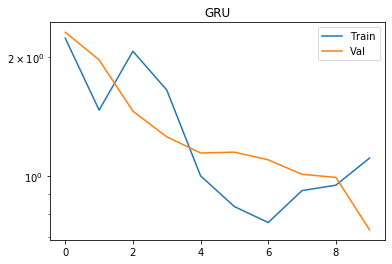

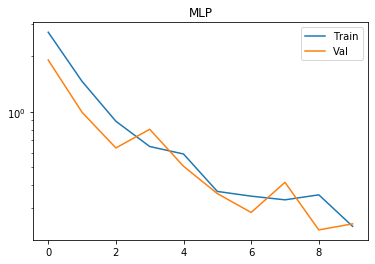

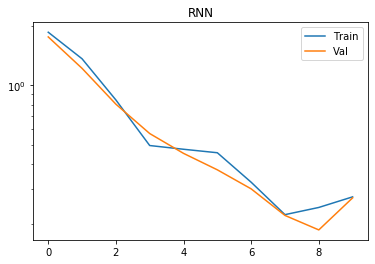

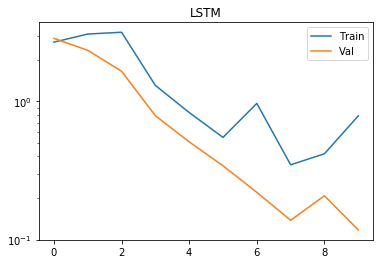

In [19]:
plot_history(gru_history,log=True,title="GRU")
plot_history(ff_history,log=True, title="MLP")
plot_history(rnn_history,log=True,title="RNN")
plot_history(lstm_history,log=True,title="LSTM")


In [20]:
# Evaluate the results on the test data. 
# Also evaluate the MSE of a naive approach which just predicts  the 
# rate in 3 months as the rate today. 
ff_eval = m_ff.evaluate_generator(test_gen, test_steps)
rnn_eval = m_rnn.evaluate_generator(test_gen, test_steps)
lstm_eval = m_lstm.evaluate_generator(test_gen, test_steps)
gru_eval = m_gru.evaluate_generator(test_gen, test_steps)

naive_eval = naive_prediction_gen(test_gen, test_steps)
pd.DataFrame({'MLP': ff_eval, 'SimpleRNN': rnn_eval, 'LSTM': lstm_eval, 'GRU': gru_eval, 'Naive': naive_eval}, index=['Test MSE'])

,MLP,SimpleRNN,LSTM,GRU,Naive
Test MSE,0.294834,0.304531,0.156218,0.647481,5.64064


In [43]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 4632), started 0:17:57 ago. (Use '!kill 4632' to kill it.)

In [38]:
# Save the models. 
now = datetime.now().strftime("%m_%d")
m_ff.save("Models\m_ff_{}.h5".format(now))
m_gru.save("Models\m_gru_{}.h5".format(now))
m_rnn.save("Models\m_rnn_{}.h5".format(now))
m_lstm.save("Models\m_lstm_{}.h5".format(now))